In [6]:
import pyLDAvis.gensim
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

import gensim
from gensim import models
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora.dictionary import Dictionary
from collections import defaultdict

import warnings
import pprint
import os
import zipfile
import re

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

Download files, set options, and initalize libraries

In [20]:
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('vader_lexicon')
stopwords = nltk.corpus.stopwords.words("english")
pd.set_option("display.max_colwidth", 200)
pd.set_option('display.max_rows', None)
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AbuAh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\AbuAh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AbuAh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AbuAh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\AbuAh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Download and initialize glove dictionary

In [ ]:
import os
import urllib.request
os.makedirs('C:\\tmp', exist_ok=True)
urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.6B.zip', 'C:\\tmp\\glove.6B.zip')
with zipfile.ZipFile('C:\\tmp\\glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('C:\\tmp\\glove')

In [12]:
# create dictionary for glove
embeddings_index = {}
with open('C:\\tmp\\glove\\glove.6B.100d.txt', 'r', encoding='utf-8') as temp:
    for line in temp:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

Function to remove nonenglish and meaningless words

In [13]:
meaningless_words = [
    "theyre", "unable", "today", "caused", "right", "line", "enter", "hold", "taking",
    "lisa", "ines", "susan", "mike", "many", "placed", "many", "marty", "ines", "ryan",
    "cassy", "joseph", "matthew", "lissa", "nicole", "annette", "rachel", "rosie", "make",
    "phil", "mark", "viviana", "going", "came", "acct", "sure", "hope", "youre", "dont",
    "cant", "much", "something", "thank", "thanks", "please", "let", "may", "via", "back",
    "would", "need", "like", "using", "day", "know", "heard", "take", "see", "made",
    "someone", "wed", "welcome", "tell", "what", "whats", "feel", "type", "havent",
    "want", "get", "reach", "within", "with", "hear", "etc", "im", "one", "saw",
    "hello", "wanted", "also", "hey", "reaching", "look", "could", "full", "youd",
    "could", "looking", "way", "able", "lookout", "try", "show", "bit", "yes", "isnt",
    "tried", "gotcha", "didnt", "might"
]

def remove_nonenglish_meaningless(word_list):
    cleaned_word_list = []
    for word in word_list:
        # word cannot be in meaningless array
        if word not in meaningless_words:
            try:
                # append word if word exists in dictionary
                embeddings_index[word]
                cleaned_word_list.append(word)
            except:
                pass
    return cleaned_word_list

Process the data and create dataframes
- Lowercase everything
- Remove symbols
- Remove extra whitespace
- Tokenize tweets
- Remove stopwords
- Lemmatize tweets
- Remove nonenglish words
- Remove meaningless words
- Drop unnecessary columns
- Set minimum length for tweets
- Remove empty values

In [ ]:
def process_data(url):
    csv = pd.read_csv(url)
    df = pd.DataFrame(csv)

    df.replace("", np.nan, inplace=True)
    df.dropna(inplace=True)
    df = df[df["Tweet"].str.len() >= 80]
    df = df.reset_index(drop=True)
    df = df.drop(['Tweet ID', 'URL', 'Username', 'User Bio'], axis=1)

    df["tweet-cleaned"] = df["Tweet"].str.lower().str.replace('[^A-Za-z ]','').str.replace(' +',' ').str.strip().str.replace('[^a-zA-Z\s]', '', regex=True)
    df["tweet-cleaned"] = df["tweet-cleaned"].fillna('').apply(lambda word: word_tokenize(word))
    df["tweet-cleaned"] = df["tweet-cleaned"].apply(lambda word_list: [word for word in word_list if word not in stopwords])

    df["tweet-cleaned-lemma"] = df["tweet-cleaned"].apply(lambda word_list: [lemmatizer.lemmatize(word) for word in word_list])
    df["tweet-cleaned-lemma"] = df["tweet-cleaned-lemma"].apply(lambda word_list: remove_nonenglish_meaningless(word_list))
    return df

americanexpress_df = process_data("data/americanexpress.csv")
bankofamerica_df = process_data("data/bankofamerica.csv")
wellsfargo_df = process_data("data/wellsfargo.csv")
capitalone_df = process_data("data/capitalone.csv")
chase_df = process_data("data/chase.csv")
citi_df = process_data("data/citi.csv")

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
C:\Users\AbuAh\AppData\Local\Temp\ipykernel_33400\3107309966.py:11: SyntaxWarning: invalid escape sequence '\s'
  df["tweet-cleaned"] = df["Tweet"].str.lower().str.replace('[^A-Za-z ]','').str.replace(' +',' ').str.strip().str.replace('[^a-zA-Z\s]', '', regex=True)


Function to turn dataframe to array

In [22]:
def df_to_array(df):
    document_arr = []
    for index, row in df.iterrows():
        row = row["tweet-cleaned-lemma"]
        # rows cannot be blank
        if len(row) == 0:
            continue
        document = []
        for word in row:
            # words must be at least 4 chars
            if len(word) < 4:
                continue
            document.append(word)
        if len(document) > 0:
            document_arr.append(document)
    return document_arr

Function to perform topic modelling when number of topics is unknown
(finds best number of topics using coherence values)


In [23]:
def topic_modelling_num_topics_unknown(df, testing_limit):
    FREQUENCY_REQUIREMENT = 1
    document_arr = df_to_array(df)

    # counts frequency of each word
    frequency = defaultdict(int)
    for document in document_arr:
        for word in document:
             frequency[word] += 1

    # creates corpus of words with enough frequency
    processed_corpus = [[word for word in document if frequency[word] > FREQUENCY_REQUIREMENT] for document in document_arr]
    dictionary = corpora.Dictionary(processed_corpus)
    bow_corpus = [dictionary.doc2bow(document) for document in processed_corpus]

    # creates ldamodels with variable number of topics and records coherence values
    def simulate_coherence_values(dictionary, corpus, texts, testing_limit):
        coherence_values_arr = []
        num_topics_arr = []
        for num_topics in range(2, testing_limit):
            lda_model = models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=np.random.RandomState(100))
            coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values_arr.append(coherencemodel.get_coherence())
            num_topics_arr.append(num_topics)
        return coherence_values_arr, num_topics_arr

    coherence_values_arr, num_topics_arr = simulate_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=df["tweet-cleaned-lemma"], testing_limit=testing_limit)

    # finds and returns model with highest coherence value
    best_num_topics = 0
    highest_cv_value = 0
    for i in range(len(coherence_values_arr)):
        if coherence_values_arr[i] > highest_cv_value:
            highest_cv_value = coherence_values_arr[i]
            best_num_topics = num_topics_arr[i]

    lda_model = models.LdaMulticore(corpus=bow_corpus, id2word=dictionary, num_topics=best_num_topics, random_state=np.random.RandomState(100))
    return lda_model, best_num_topics, bow_corpus

Function to perform topic modelling when number of topics is known

In [24]:
def topic_modelling_num_topics_manual(df, num_topics):
    FREQUENCY_REQUIREMENT = 1
    document_arr = df_to_array(df)

    # counts frequency of each word
    frequency = defaultdict(int)
    for document in document_arr:
        for word in document:
             frequency[word] += 1

    # creates corpus of words with enough frequency
    processed_corpus = [[word for word in document if frequency[word] > FREQUENCY_REQUIREMENT] for document in document_arr]
    dictionary = corpora.Dictionary(processed_corpus)
    bow_corpus = [dictionary.doc2bow(document) for document in processed_corpus]

    # returns model with chosen number of topics
    lda_model = models.LdaMulticore(corpus=bow_corpus, id2word=dictionary, num_topics=num_topics, random_state=np.random.RandomState(100))
    return lda_model, num_topics, bow_corpus

Performs topic modelling on each bank given ideal number of topics

In [25]:
americanexpress_model, americanexpress_num_topics, americanexpress_corpus = topic_modelling_num_topics_manual(df=americanexpress_df, num_topics=4)
bankofamerica_model, bankofamerica_num_topics, bankofamerica_corpus = topic_modelling_num_topics_manual(df=bankofamerica_df, num_topics=4)
wellsfargo_model, wellsfargo_num_topics, wellsfargo_corpus = topic_modelling_num_topics_manual(df=wellsfargo_df, num_topics=3)
capitalone_model, capitalone_num_topics, capitalone_corpus = topic_modelling_num_topics_manual(df=capitalone_df, num_topics=7)
chase_model, chase_num_topics, chase_corpus = topic_modelling_num_topics_manual(df=chase_df, num_topics=8)
citi_model, citi_num_topics, citi_corpus = topic_modelling_num_topics_manual(df=citi_df, num_topics=6)

Prints the first 30 words of each topic from each bank



In [26]:
NUMBER_WORDS = 30
print("American Express topics: " + str(americanexpress_num_topics))
pprint.pprint(americanexpress_model.print_topics(num_words=NUMBER_WORDS))

print("Bank of America topics: " + str(bankofamerica_num_topics))
pprint.pprint(bankofamerica_model.print_topics(num_words=NUMBER_WORDS))

print("Wells Fargo topics: " + str(wellsfargo_num_topics))
pprint.pprint(wellsfargo_model.print_topics(num_words=NUMBER_WORDS))

print("Capital One topics: " + str(capitalone_num_topics))
pprint.pprint(capitalone_model.print_topics(num_words=NUMBER_WORDS))

print("Chase topics: " + str(chase_num_topics))
pprint.pprint(chase_model.print_topics(num_words=NUMBER_WORDS))

print("Citi topics: " + str(citi_num_topics))
pprint.pprint(citi_model.print_topics(num_words=NUMBER_WORDS))

American Express topics: 4
[(0,
  '0.050*"card" + 0.021*"number" + 0.021*"account" + 0.019*"information" + '
  '0.015*"available" + 0.015*"service" + 0.013*"help" + 0.013*"sorry" + '
  '0.012*"personal" + 0.010*"contact" + 0.010*"chat" + 0.009*"amex" + '
  '0.009*"email" + 0.009*"phone" + 0.009*"team" + 0.008*"detail" + '
  '0.008*"customer" + 0.008*"read" + 0.008*"name" + 0.008*"experience" + '
  '0.008*"online" + 0.007*"release" + 0.007*"call" + 0.007*"channel" + '
  '0.007*"time" + 0.007*"review" + 0.007*"issued" + 0.007*"product" + '
  '0.006*"address" + 0.006*"member"'),
 (1,
  '0.041*"card" + 0.037*"morning" + 0.034*"chat" + 0.030*"assistance" + '
  '0.023*"account" + 0.020*"good" + 0.020*"immediate" + 0.017*"help" + '
  '0.017*"number" + 0.016*"customer" + 0.013*"twitter" + 0.013*"reply" + '
  '0.013*"well" + 0.012*"contact" + 0.012*"logging" + 0.012*"time" + '
  '0.012*"resource" + 0.012*"helpful" + 0.012*"button" + 0.011*"call" + '
  '0.011*"clicking" + 0.011*"follow" + 0.011*

Creates and saves pyLDAvis visualizations of each banks' topics



In [27]:
pyLDAvis.enable_notebook()
americanexpress_vis = pyLDAvis.gensim.prepare(americanexpress_model, americanexpress_corpus, dictionary=americanexpress_model.id2word)
bankofamerica_vis = pyLDAvis.gensim.prepare(bankofamerica_model, bankofamerica_corpus, dictionary=bankofamerica_model.id2word)
wellsfargo_vis = pyLDAvis.gensim.prepare(wellsfargo_model, wellsfargo_corpus, dictionary=wellsfargo_model.id2word)
capitalone_vis = pyLDAvis.gensim.prepare(capitalone_model, capitalone_corpus, dictionary=capitalone_model.id2word)
chase_vis = pyLDAvis.gensim.prepare(chase_model, chase_corpus, dictionary=chase_model.id2word)
citi_vis = pyLDAvis.gensim.prepare(citi_model, citi_corpus, dictionary=citi_model.id2word)

pyLDAvis.save_html(americanexpress_vis, 'americanexpress.html')
pyLDAvis.save_html(bankofamerica_vis, 'bankofamerica.html')
pyLDAvis.save_html(wellsfargo_vis, 'wellsfargo.html')
pyLDAvis.save_html(capitalone_vis, 'capitalone.html')
pyLDAvis.save_html(chase_vis, 'chase.html')
pyLDAvis.save_html(citi_vis, 'citi.html')

Divides the Citi dataframe into years

In [28]:
def count_tweets_from_year(df, years):
    # counts tweets from bank for given year
    times = 0
    for index, row in df.iterrows():
        if years in row["Timestamp"]:
            times += 1
    return times

num_times_2023 = count_tweets_from_year(citi_df, '2023')
num_times_2022 = num_times_2023 + count_tweets_from_year(citi_df, '2022')
num_times_2021 = num_times_2022 + count_tweets_from_year(citi_df, '2021')
num_times_2020 = num_times_2021 + count_tweets_from_year(citi_df, '2020')
num_times_2019 = num_times_2020 + count_tweets_from_year(citi_df, '2019')
num_times_2018 = num_times_2019 + count_tweets_from_year(citi_df, '2018')

citi_2023_df = citi_df.head(num_times_2023)
citi_2022_df = citi_df.iloc[num_times_2023:num_times_2022]
citi_2021_df = citi_df.iloc[num_times_2022:num_times_2021]
citi_2020_df = citi_df.iloc[num_times_2021:num_times_2020]
citi_2019_df = citi_df.iloc[num_times_2020:num_times_2019]
citi_2018_df = citi_df.iloc[num_times_2019:num_times_2018]

Performs topic modelling on each year given ideal number of topics

In [29]:
citi_2023_model, citi_2023_num_topics, citi_2023_corpus = topic_modelling_num_topics_manual(df=citi_2023_df, num_topics=3)
citi_2022_model, citi_2022_num_topics, citi_2022_corpus = topic_modelling_num_topics_manual(df=citi_2022_df, num_topics=4)
citi_2021_model, citi_2021_num_topics, citi_2021_corpus = topic_modelling_num_topics_manual(df=citi_2021_df, num_topics=4)
citi_2020_model, citi_2020_num_topics, citi_2020_corpus = topic_modelling_num_topics_manual(df=citi_2020_df, num_topics=4)
citi_2019_model, citi_2019_num_topics, citi_2019_corpus = topic_modelling_num_topics_manual(df=citi_2019_df, num_topics=3)
citi_2018_model, citi_2018_num_topics, citi_2018_corpus = topic_modelling_num_topics_manual(df=citi_2018_df, num_topics=3)

Prints the first 30 words of each topic from each year

In [30]:
NUMBER_WORDS = 30
print("Year_2023" + str(citi_2023_num_topics))
pprint.pprint(citi_2023_model.print_topics(num_words=NUMBER_WORDS))

print("Year_2022" + str(citi_2022_num_topics))
pprint.pprint(citi_2022_model.print_topics(num_words=NUMBER_WORDS))

print("Year_2023" + str(citi_2021_num_topics))
pprint.pprint(citi_2021_model.print_topics(num_words=NUMBER_WORDS))

print("Year_2020" + str(citi_2020_num_topics))
pprint.pprint(citi_2020_model.print_topics(num_words=NUMBER_WORDS))

print("Year_2019" + str(citi_2019_num_topics))
pprint.pprint(citi_2019_model.print_topics(num_words=NUMBER_WORDS))

print("Year_2018" + str(citi_2018_num_topics))
pprint.pprint(citi_2019_model.print_topics(num_words=NUMBER_WORDS))

Year_20233
[(0,
  '0.040*"account" + 0.032*"help" + 0.029*"contact" + 0.026*"number" + '
  '0.025*"send" + 0.021*"detail" + 0.018*"business" + 0.016*"donnie" + '
  '0.016*"assistance" + 0.015*"deanna" + 0.013*"link" + 0.012*"india" + '
  '0.012*"provide" + 0.012*"follow" + 0.012*"message" + 0.011*"allow" + '
  '0.011*"john" + 0.011*"card" + 0.010*"country" + 0.010*"partner" + '
  '0.009*"citi" + 0.009*"citibank" + 0.009*"tweet" + 0.009*"concern" + '
  '0.008*"assist" + 0.008*"opened" + 0.008*"visit" + 0.008*"request" + '
  '0.008*"regret" + 0.008*"include"'),
 (1,
  '0.078*"account" + 0.038*"number" + 0.028*"assistance" + 0.025*"country" + '
  '0.023*"detail" + 0.021*"help" + 0.021*"opened" + 0.018*"include" + '
  '0.017*"india" + 0.015*"citi" + 0.013*"send" + 0.013*"still" + 0.013*"link" '
  '+ 0.012*"contact" + 0.012*"deanna" + 0.012*"assist" + 0.012*"message" + '
  '0.011*"reply" + 0.011*"team" + 0.010*"sorry" + 0.010*"concern" + '
  '0.009*"response" + 0.009*"business" + 0.009*"par

Creates and saves pyLDAvis visualizations of each years' topics

In [31]:
pyLDAvis.enable_notebook()
citi_2023_vis = pyLDAvis.gensim.prepare(citi_2023_model, citi_2023_corpus, dictionary=citi_2023_model.id2word)
citi_2022_vis = pyLDAvis.gensim.prepare(citi_2022_model, citi_2022_corpus, dictionary=citi_2022_model.id2word)
citi_2021_vis = pyLDAvis.gensim.prepare(citi_2021_model, citi_2021_corpus, dictionary=citi_2021_model.id2word)
citi_2020_vis = pyLDAvis.gensim.prepare(citi_2020_model, citi_2020_corpus, dictionary=citi_2020_model.id2word)
citi_2019_vis = pyLDAvis.gensim.prepare(citi_2019_model, citi_2019_corpus, dictionary=citi_2019_model.id2word)
citi_2018_vis = pyLDAvis.gensim.prepare(citi_2018_model, citi_2018_corpus, dictionary=citi_2018_model.id2word)

pyLDAvis.save_html(citi_2023_vis, '2023.html')
pyLDAvis.save_html(citi_2022_vis, '2022.html')
pyLDAvis.save_html(citi_2021_vis, '2021.html')
pyLDAvis.save_html(citi_2020_vis, '2020.html')
pyLDAvis.save_html(citi_2019_vis, '2019.html')
pyLDAvis.save_html(citi_2018_vis, '2018.html')

Performs sentiment analysis using TextBlob for each bank

In [32]:
def analyze_sentiment_textblob(df):
    def analyze_sentiment_textblob(text):
        analysis = TextBlob(text)
        if analysis.sentiment.polarity > 0:
            return "Positive"
        elif analysis.sentiment.polarity == 0:
            return "Neutral"
        else:
            return "Negative"
    df['tweet-sentiment-textblob'] = df["Tweet"].apply(analyze_sentiment_textblob)
    return df

americanexpress_df = analyze_sentiment_textblob(americanexpress_df)
bankofamerica_df = analyze_sentiment_textblob(bankofamerica_df)
wellsfargo_df = analyze_sentiment_textblob(wellsfargo_df)
capitalone_df = analyze_sentiment_textblob(capitalone_df)
chase_df = analyze_sentiment_textblob(chase_df)
citi_df = analyze_sentiment_textblob(citi_df)

Creates a bar chart and pie chart of TextBlob sentiment analysis results for each bank

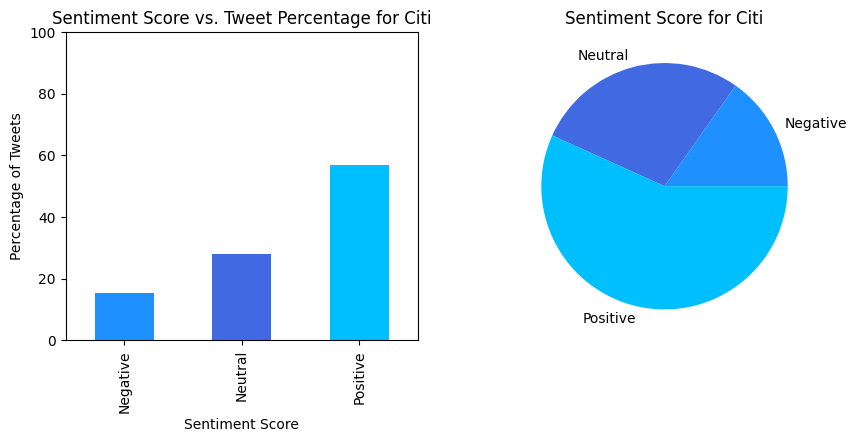

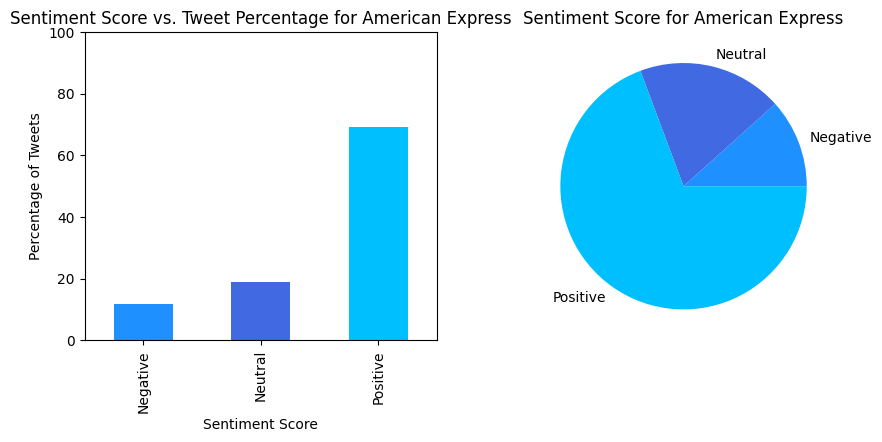

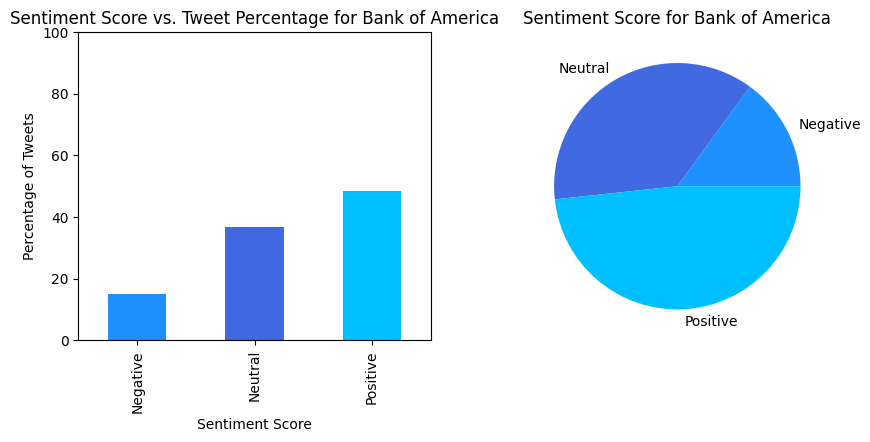

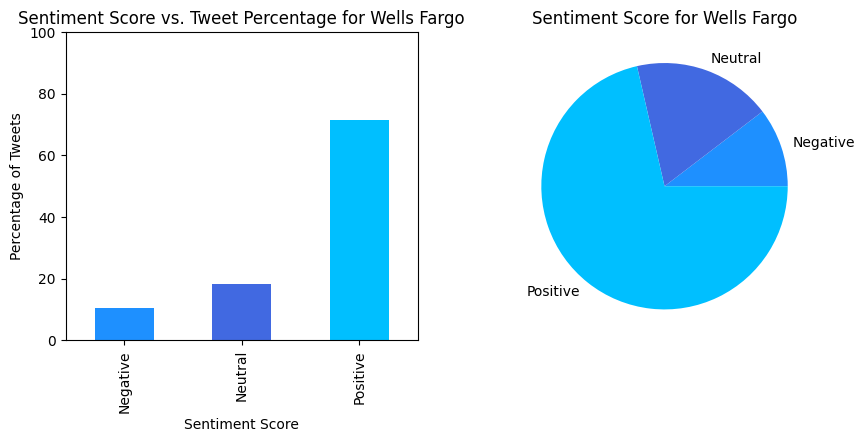

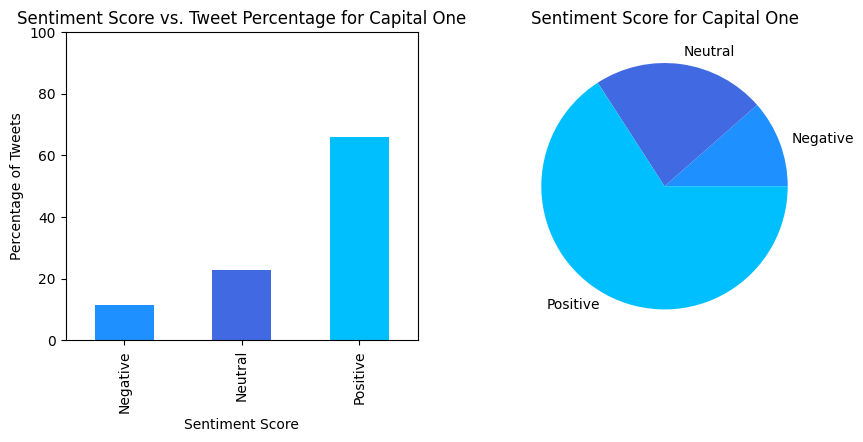

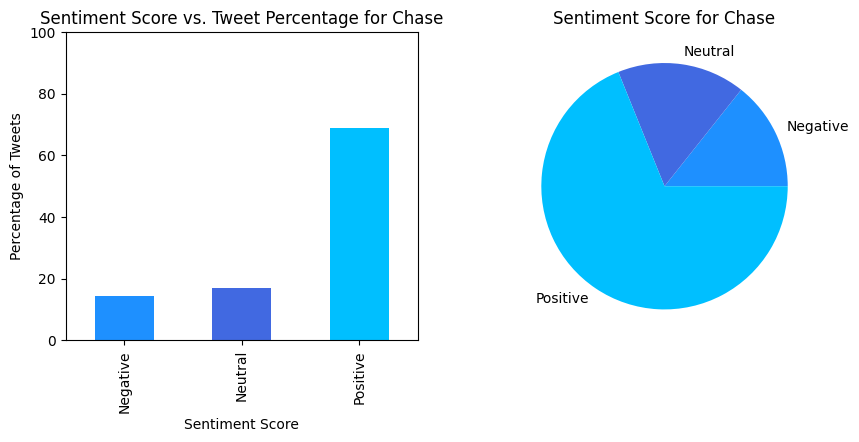

In [33]:
bank_dfs = {
    "Citi": citi_df,
    "American Express": americanexpress_df,
    "Bank of America": bankofamerica_df,
    "Wells Fargo": wellsfargo_df,
    "Capital One": capitalone_df,
    "Chase": chase_df
}

for bank_name, df in bank_dfs.items():
    fig, subPlot = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    GroupedData = df.groupby('tweet-sentiment-textblob').size()

    # convert frequency to percentage
    total_tweets = len(df)
    percentages = (GroupedData / total_tweets) * 100

    bar_chart = percentages.plot(kind='bar', ax=subPlot[0], color=['dodgerblue', 'royalblue', 'deepskyblue'])
    bar_chart.set_xlabel("Sentiment Score")
    bar_chart.set_ylabel("Percentage of Tweets")
    bar_chart.set_title("Sentiment Score vs. Tweet Percentage for " + bank_name)
    bar_chart.set_ylim(0, 100)

    pie_chart = GroupedData.plot(kind='pie', ax=subPlot[1], colors=['dodgerblue', 'royalblue', 'deepskyblue'])
    pie_chart.set_title("Sentiment Score for " + bank_name)
    plt.show()

Performs sentiment analysis using Vader for each bank

In [34]:
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment_vader(df):
    def analyze_sentiment_vader(text):
        scores = analyzer.polarity_scores(text)
        compound_score = scores['compound']
        return compound_score
    # returns value from -1 to 1 in a new df column
    df['tweet-sentiment-vader'] = df["Tweet"].apply(analyze_sentiment_vader)
    return df

americanexpress_df = analyze_sentiment_vader(americanexpress_df)
bankofamerica_df = analyze_sentiment_vader(bankofamerica_df)
wellsfargo_df = analyze_sentiment_vader(wellsfargo_df)
capitalone_df = analyze_sentiment_vader(capitalone_df)
chase_df = analyze_sentiment_vader(chase_df)
citi_df = analyze_sentiment_vader(citi_df)

Creates a scatterplot of Vader sentiment analysis results for each bank

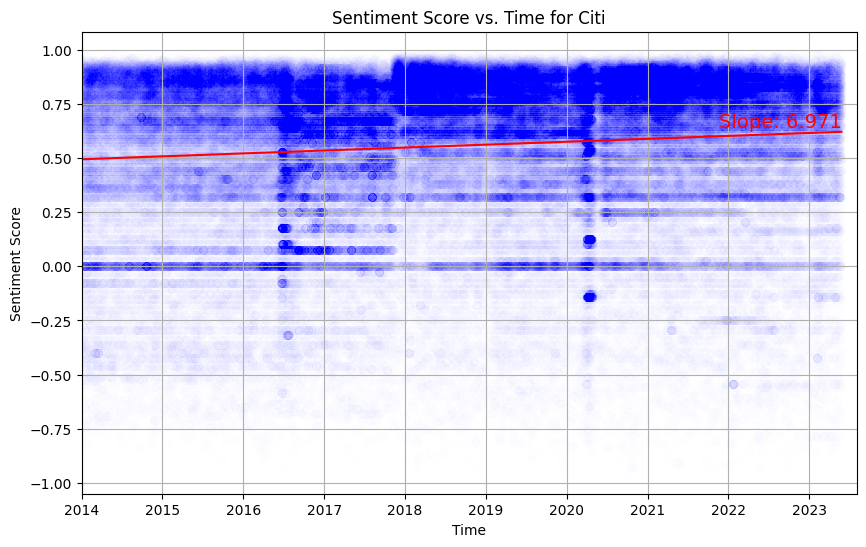

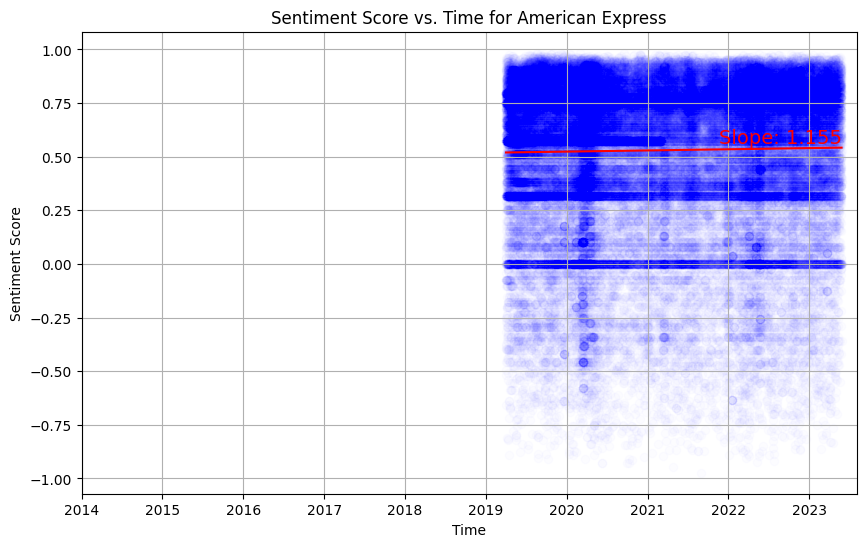

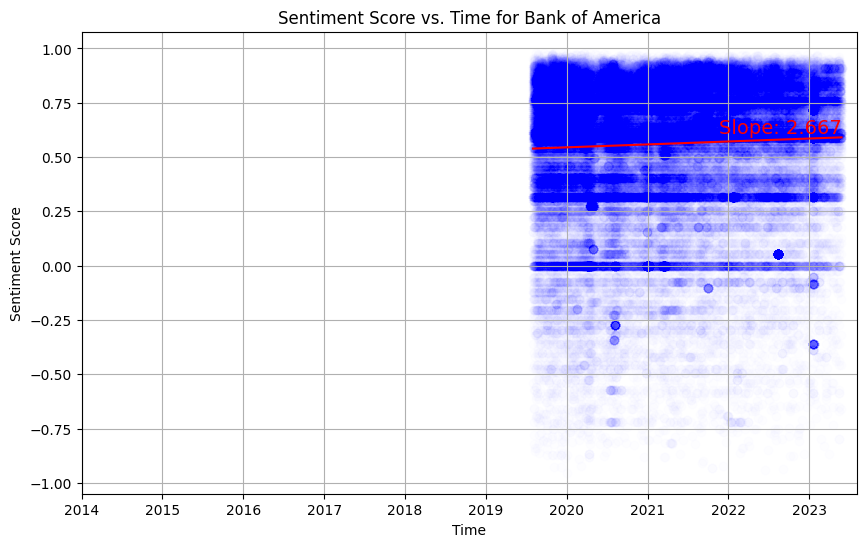

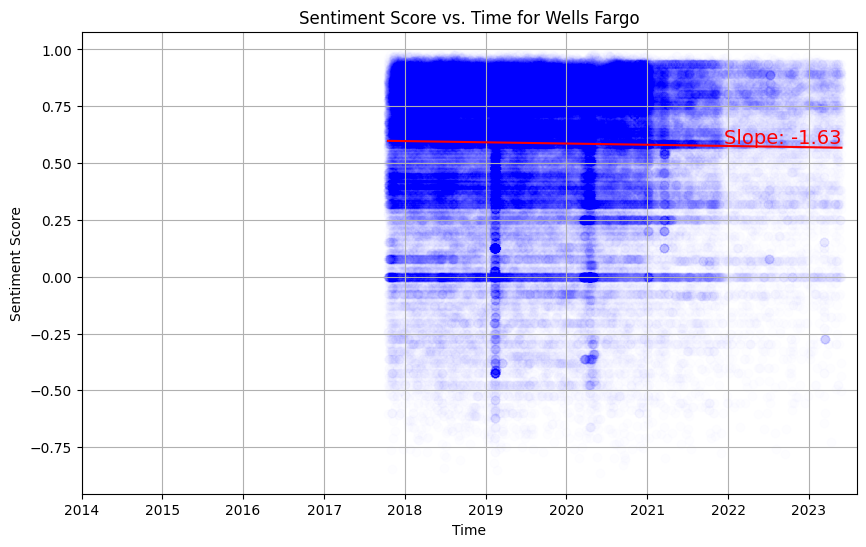

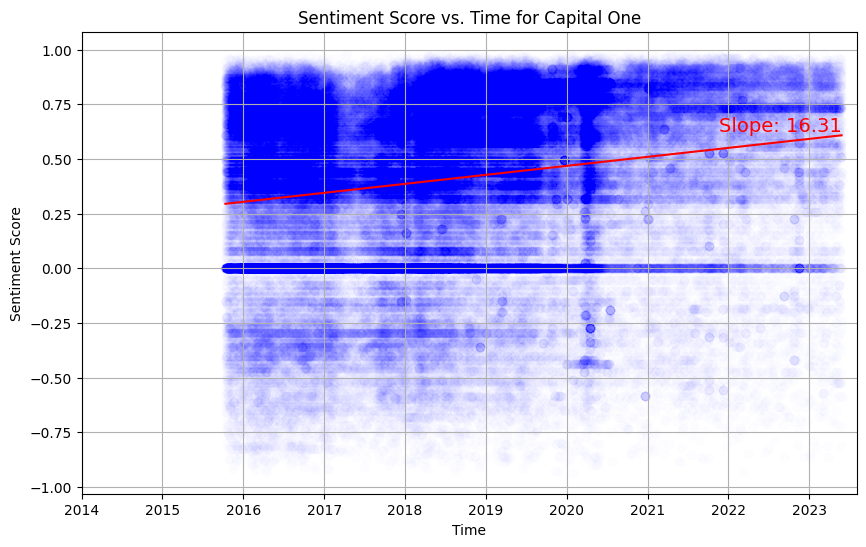

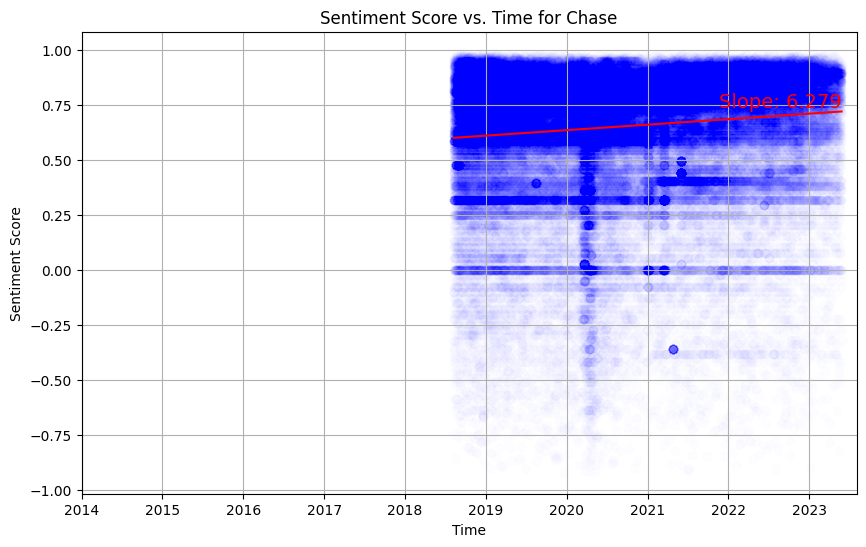

In [35]:
bank_dfs = {
    "Citi": citi_df,
    "American Express": americanexpress_df,
    "Bank of America": bankofamerica_df,
    "Wells Fargo": wellsfargo_df,
    "Capital One": capitalone_df,
    "Chase": chase_df
}

for bank_name, df in bank_dfs.items():
    # change plot opacity depending on number of tweets
    rows_num = df.shape[0]
    alpha = 1200 / rows_num

    # make timestamp format understandable
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%b %d, %Y · %I:%M %p UTC")

    # scatterplot every tweet (timestamp against score)
    plt.figure(figsize=(10, 6))
    plt.scatter(df["Timestamp"], df["tweet-sentiment-vader"], c='b', alpha=alpha)
    plt.xlabel("Time")
    plt.ylabel("Sentiment Score")
    plt.title("Sentiment Score vs. Time for " + bank_name)
    plt.grid(True)

    # set consistent limmits
    xlim_start = pd.to_datetime("2014-01-01")
    xlim_end = pd.to_datetime("2023-08-04")
    plt.xlim([xlim_start, xlim_end])

    # extract x, y values
    x = df["Timestamp"].values.astype(np.int64) // 10 ** 9
    y = df["tweet-sentiment-vader"].values

    # create trend line
    m, b = np.polyfit(x, y, 1)
    plt.plot(df["Timestamp"], m*x + b, color='red')

    x_range = np.max(x) - np.min(x)
    y_range = np.max(y) - np.min(y)
    normalized_slope = m / (y_range / x_range)

    # display slope * 100
    slope_text = f"Slope: {normalized_slope * 100}"
    plt.text(df["Timestamp"].iloc[0], m*x[0] + b, slope_text[:12], fontsize=14, color='red', ha='right', va='bottom')
    plt.show()